# **TSLA Stock Moving Average Cross Strategy**

In [1]:
!pip install ta

In [2]:
import warnings
warnings.filterwarnings("ignore")

import ta
import scipy
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from math import sqrt
import scipy.stats as ss
import statsmodels as smt
import statsmodels.api as sm
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [3]:
start_date = datetime(2020,1,1)
end_date = datetime(2023,4,28)

TSLA = yf.download('TSLA', start_date , end_date)
TSLA.reset_index(inplace = True)

[*********************100%***********************]  1 of 1 completed


In [4]:
TSLA

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500
...,...,...,...,...,...,...,...
831,2023-04-21,164.800003,166.000000,161.320007,165.080002,165.080002,123539000
832,2023-04-24,164.649994,165.649994,158.610001,162.550003,162.550003,140006600
833,2023-04-25,159.820007,163.470001,158.750000,160.669998,160.669998,121999300
834,2023-04-26,160.289993,160.669998,153.139999,153.750000,153.750000,153364100


In [5]:
# Calculate additional features
TSLA["SMA_20"] = ta.trend.sma_indicator(TSLA["Close"], window = 20, fillna = True)
TSLA["SMA_50"] = ta.trend.sma_indicator(TSLA["Close"], window = 50, fillna = True)
TSLA["SMA_10"] = ta.trend.sma_indicator(TSLA["Close"], window = 10, fillna = True)
TSLA["SMA_30"] = ta.trend.sma_indicator(TSLA["Close"], window = 30, fillna = True)

TSLA["EMA_12"] = ta.trend.ema_indicator(TSLA["Close"], window = 12, fillna = True)
TSLA["EMA_26"] = ta.trend.ema_indicator(TSLA["Close"], window = 26, fillna = True)
TSLA["EMA_40"] = ta.trend.ema_indicator(TSLA["Close"], window = 40, fillna = True)
TSLA["EMA_60"] = ta.trend.ema_indicator(TSLA["Close"], window = 60, fillna = True)

TSLA["MACD"] = ta.trend.macd(TSLA["Close"], fillna = True)
TSLA["RSI"] = ta.momentum.rsi(TSLA["Close"], fillna = True)

In [6]:
TSLA

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,SMA_30,EMA_12,EMA_26,EMA_40,EMA_60,MACD,RSI
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500,28.684000,28.684000,28.684000,28.684000,28.684000,28.684000,28.684000,28.684000,0.000000,100.000000
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,29.109000,29.109000,29.109000,29.109000,28.814769,28.746963,28.725463,28.711869,0.067806,100.000000
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,29.440222,29.440222,29.440222,29.440222,29.012907,28.847386,28.792644,28.757469,0.165522,100.000000
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,29.897833,29.897833,29.897833,29.897833,29.360255,29.026888,28.913523,28.839869,0.333367,100.000000
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,30.480133,30.480133,30.480133,30.480133,29.890882,29.307069,29.103563,28.970015,0.583813,100.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,2023-04-21,164.800003,166.000000,161.320007,165.080002,165.080002,123539000,186.435500,190.798200,180.274997,185.626666,179.692929,183.898405,184.205392,183.786858,-4.205476,35.309424
832,2023-04-24,164.649994,165.649994,158.610001,162.550003,162.550003,140006600,185.042500,189.902800,178.078998,185.263666,177.055556,182.317042,183.149032,183.090568,-5.261486,33.974557
833,2023-04-25,159.820007,163.470001,158.750000,160.669998,160.669998,121999300,183.485500,189.178400,175.466998,184.803333,174.534701,180.713557,182.052494,182.355467,-6.178856,32.976902
834,2023-04-26,160.289993,160.669998,153.139999,153.750000,153.750000,153364100,181.713499,188.360600,172.787999,183.819667,171.337055,178.716257,180.671884,181.417583,-7.379202,29.538571


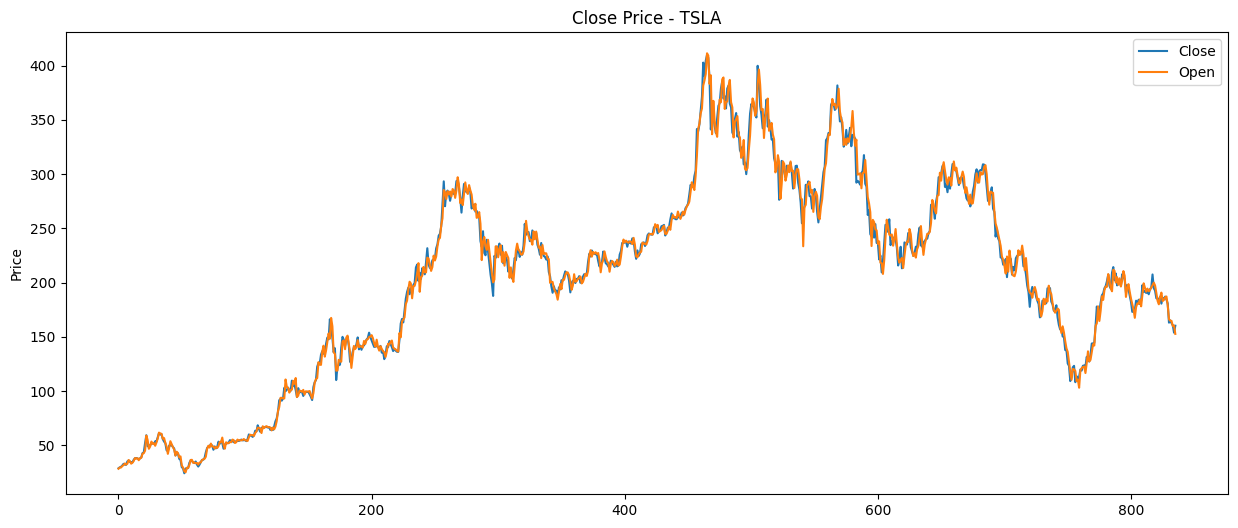

In [7]:
TSLA[['Close', 'Open']].plot(figsize=(15,6))
plt.title('Close Price - TSLA')
plt.ylabel('Price')
plt.show()

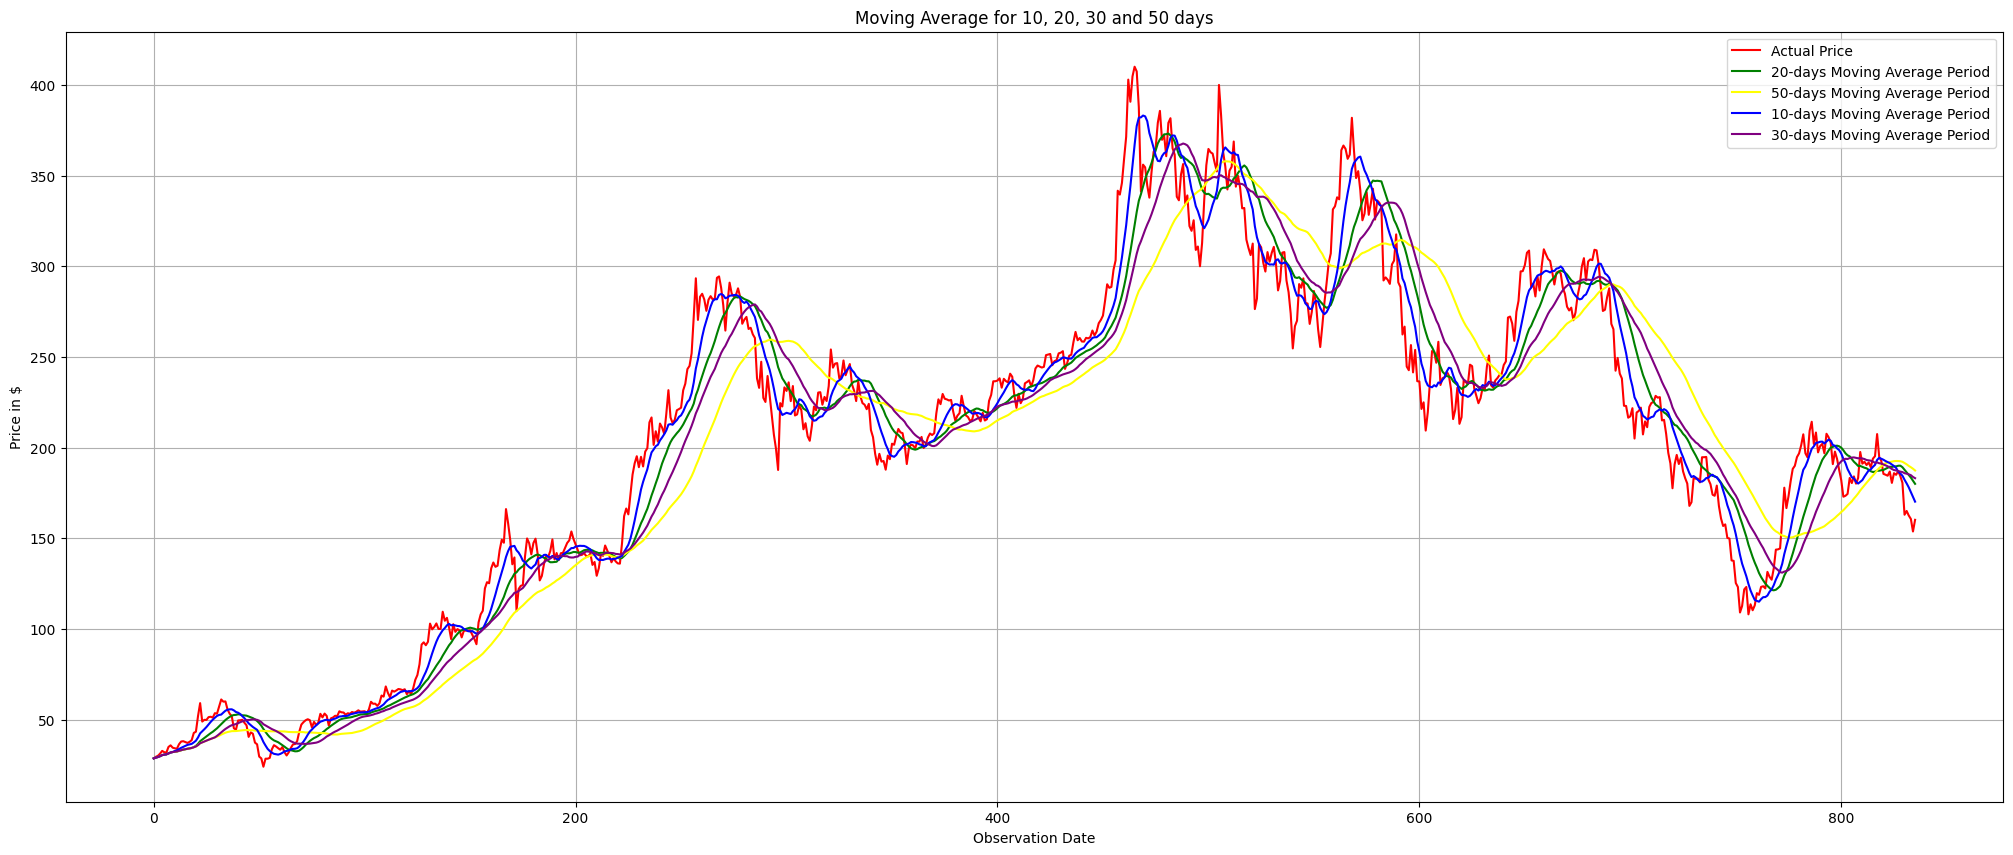

In [8]:
fig = plt.figure(figsize = (25,10))

# plot close price, short-term and long-term moving averages
TSLA['Close'].plot(label='Actual Price', color = 'red')
TSLA['SMA_20'].plot(label = '20-days Moving Average Period', color = 'green')
TSLA['SMA_50'].plot(label = '50-days Moving Average Period', color = 'yellow')
TSLA['SMA_10'].plot(label = '10-days Moving Average Period', color = 'blue')
TSLA['SMA_30'].plot(label = '30-days Moving Average Period', color = 'purple')

plt.ylabel('Price in $')
plt.xlabel('Observation Date')
plt.title('Moving Average for 10, 20, 30 and 50 days')
plt.legend()
plt.grid()
plt.show()

fig.savefig('SMA_Plot.png')

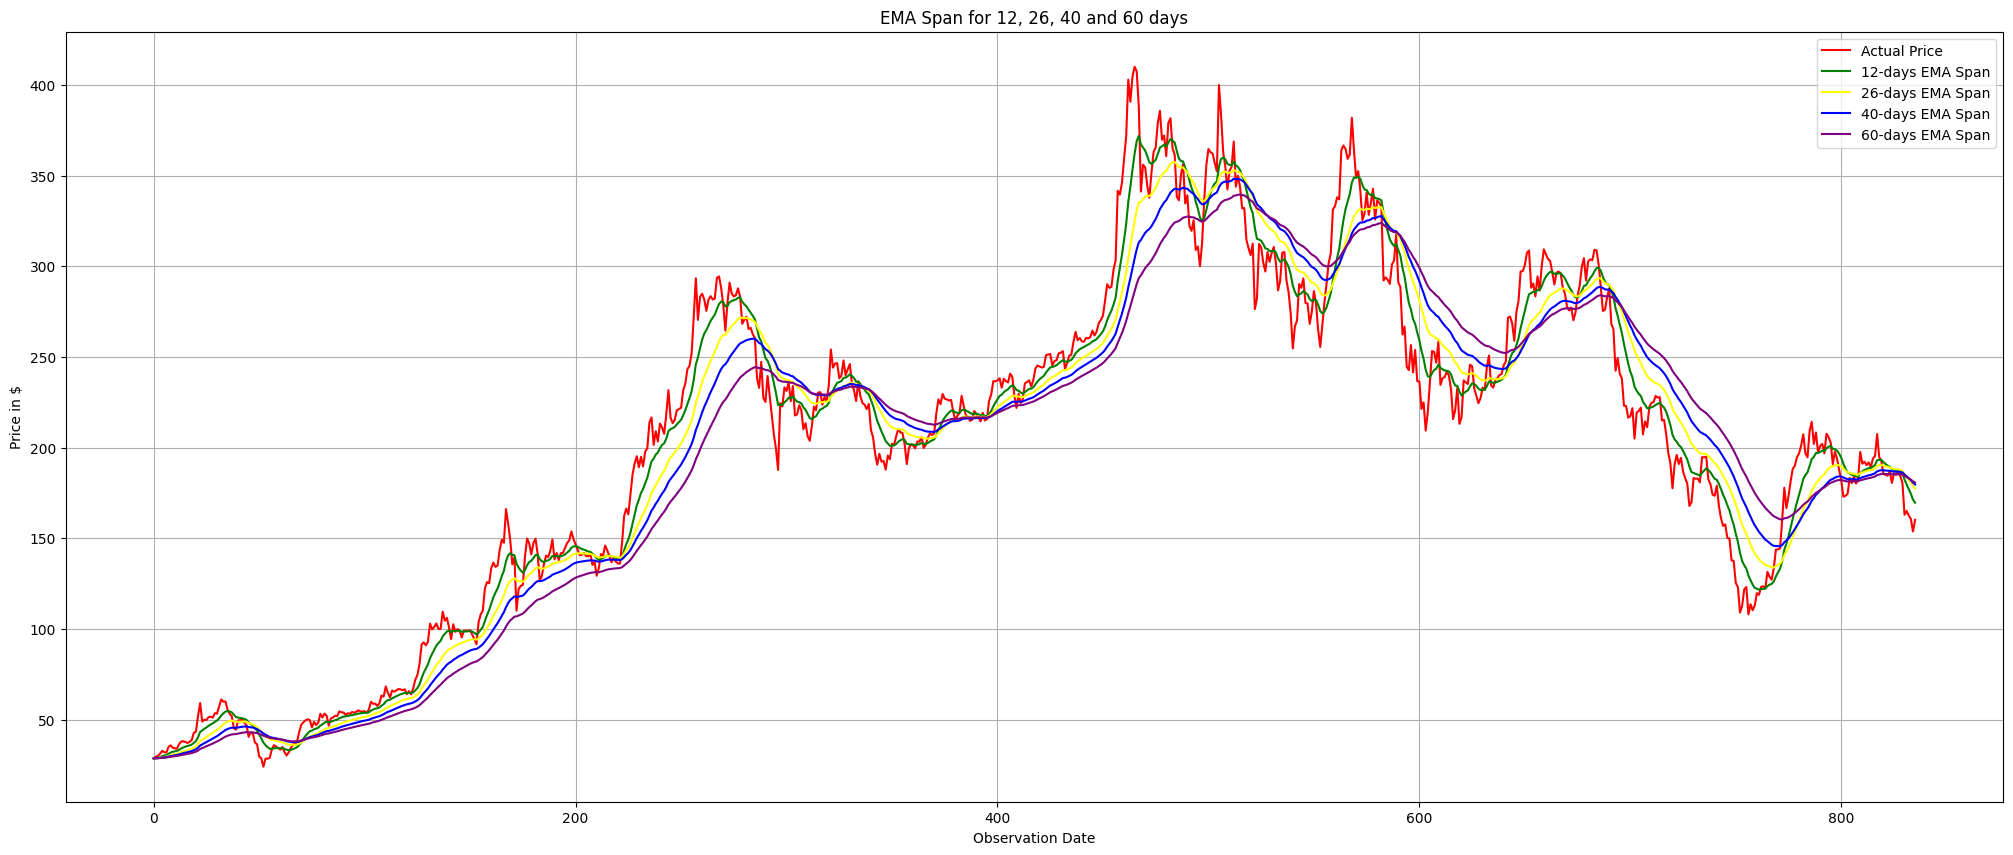

In [9]:
fig = plt.figure(figsize = (25,10))

# plot close price, short-term and long-term moving averages
TSLA['Close'].plot(label='Actual Price', color = 'red')
TSLA['EMA_12'].plot(label = '12-days EMA Span', color = 'green')
TSLA['EMA_26'].plot(label = '26-days EMA Span', color = 'yellow')
TSLA['EMA_40'].plot(label = '40-days EMA Span', color = 'blue')
TSLA['EMA_60'].plot(label = '60-days EMA Span', color = 'purple')

plt.ylabel('Price in $')
plt.xlabel('Observation Date')
plt.title('EMA Span for 12, 26, 40 and 60 days')
plt.legend()
plt.grid()
plt.show()

fig.savefig('EMA_Plot.png')

In [10]:
TSLA['SMA_Signal'] = 0.0
TSLA['SMA_Signal'] = np.where(TSLA['SMA_20'] > TSLA['SMA_50'], 1.0, 0.0)

TSLA['SMA_Position'] = TSLA['SMA_Signal'].diff()
# display first few rows
TSLA.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,SMA_30,EMA_12,EMA_26,EMA_40,EMA_60,MACD,RSI,SMA_Signal,SMA_Position
0,2020-01-02,28.299999,28.713333,28.114000,28.684000,28.684000,142981500,28.684000,28.684000,28.684000,28.684000,28.684000,28.684000,28.684000,28.684000,0.000000,100.0,0.0,NaN
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,29.109000,29.109000,29.109000,29.109000,28.814769,28.746963,28.725463,28.711869,0.067806,100.0,0.0,0.0
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,29.440222,29.440222,29.440222,29.440222,29.012907,28.847386,28.792644,28.757469,0.165522,100.0,0.0,0.0
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,29.897833,29.897833,29.897833,29.897833,29.360255,29.026888,28.913523,28.839869,0.333367,100.0,0.0,0.0
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,30.480133,30.480133,30.480133,30.480133,29.890882,29.307069,29.103563,28.970015,0.583813,100.0,0.0,0.0


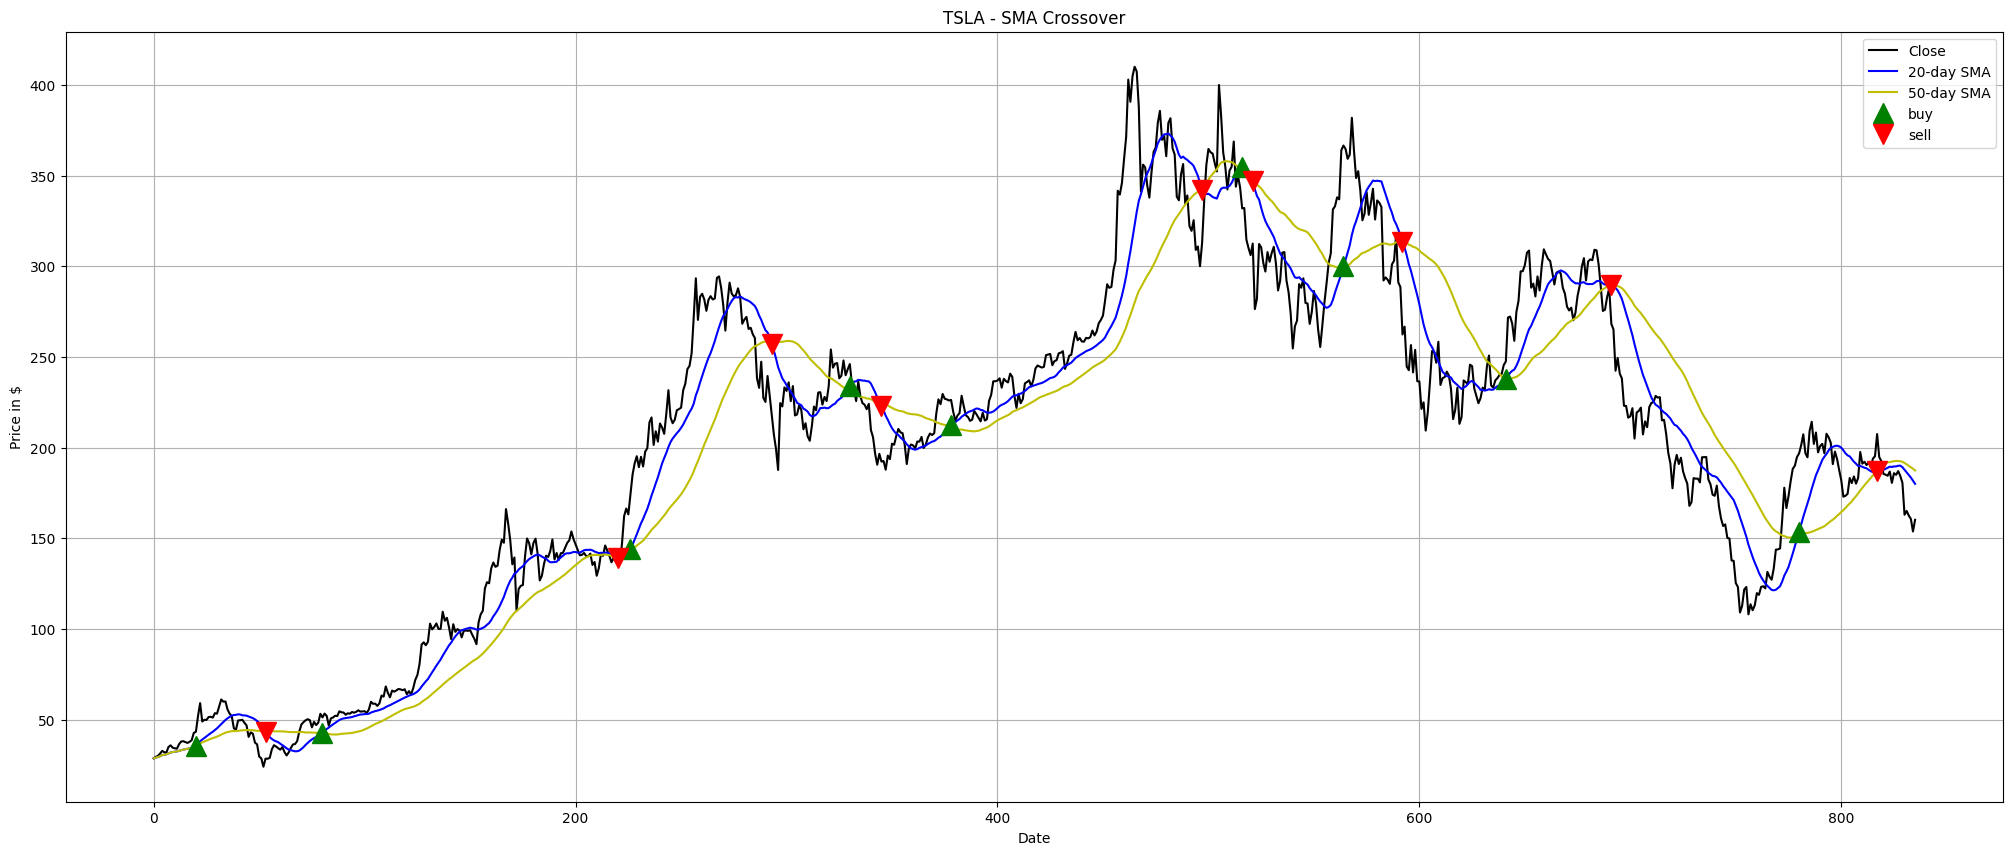

In [11]:
fig = plt.figure(figsize = (25,10))

# plot close price, short-term and long-term moving averages
TSLA['Close'].plot(color = 'k', label= 'Close')
TSLA['SMA_20'].plot(color = 'b',label = '20-day SMA')
TSLA['SMA_50'].plot(color = 'y',label = '50-day SMA')

# plot ‘buy’ signals
plt.plot(TSLA[TSLA['SMA_Position'] == 1].index,
         TSLA['SMA_20'][TSLA['SMA_Position'] == 1],
         '^', markersize = 15, color = 'g', label = 'buy')

# plot ‘sell’ signals
plt.plot(TSLA[TSLA['SMA_Position'] == -1].index,
         TSLA['SMA_20'][TSLA['SMA_Position'] == -1],
         'v', markersize = 15, color = 'r', label = 'sell')
plt.ylabel('Price in $')
plt.xlabel('Date')
plt.title('TSLA - SMA Crossover')
plt.legend()
plt.grid()
plt.show()

fig.savefig('SMA_Crossover_Plot.png')

In [12]:
# Create a new column 'Signal' such that if 12-day EMA is greater than 26-day EMA then set Signal as 1 else 0
TSLA['EMA_Signal'] = 0.0
TSLA['EMA_Signal'] = np.where(TSLA['EMA_12'] > TSLA['EMA_26'], 1.0, 0.0)
TSLA['EMA_Position'] = TSLA['EMA_Signal'].diff()

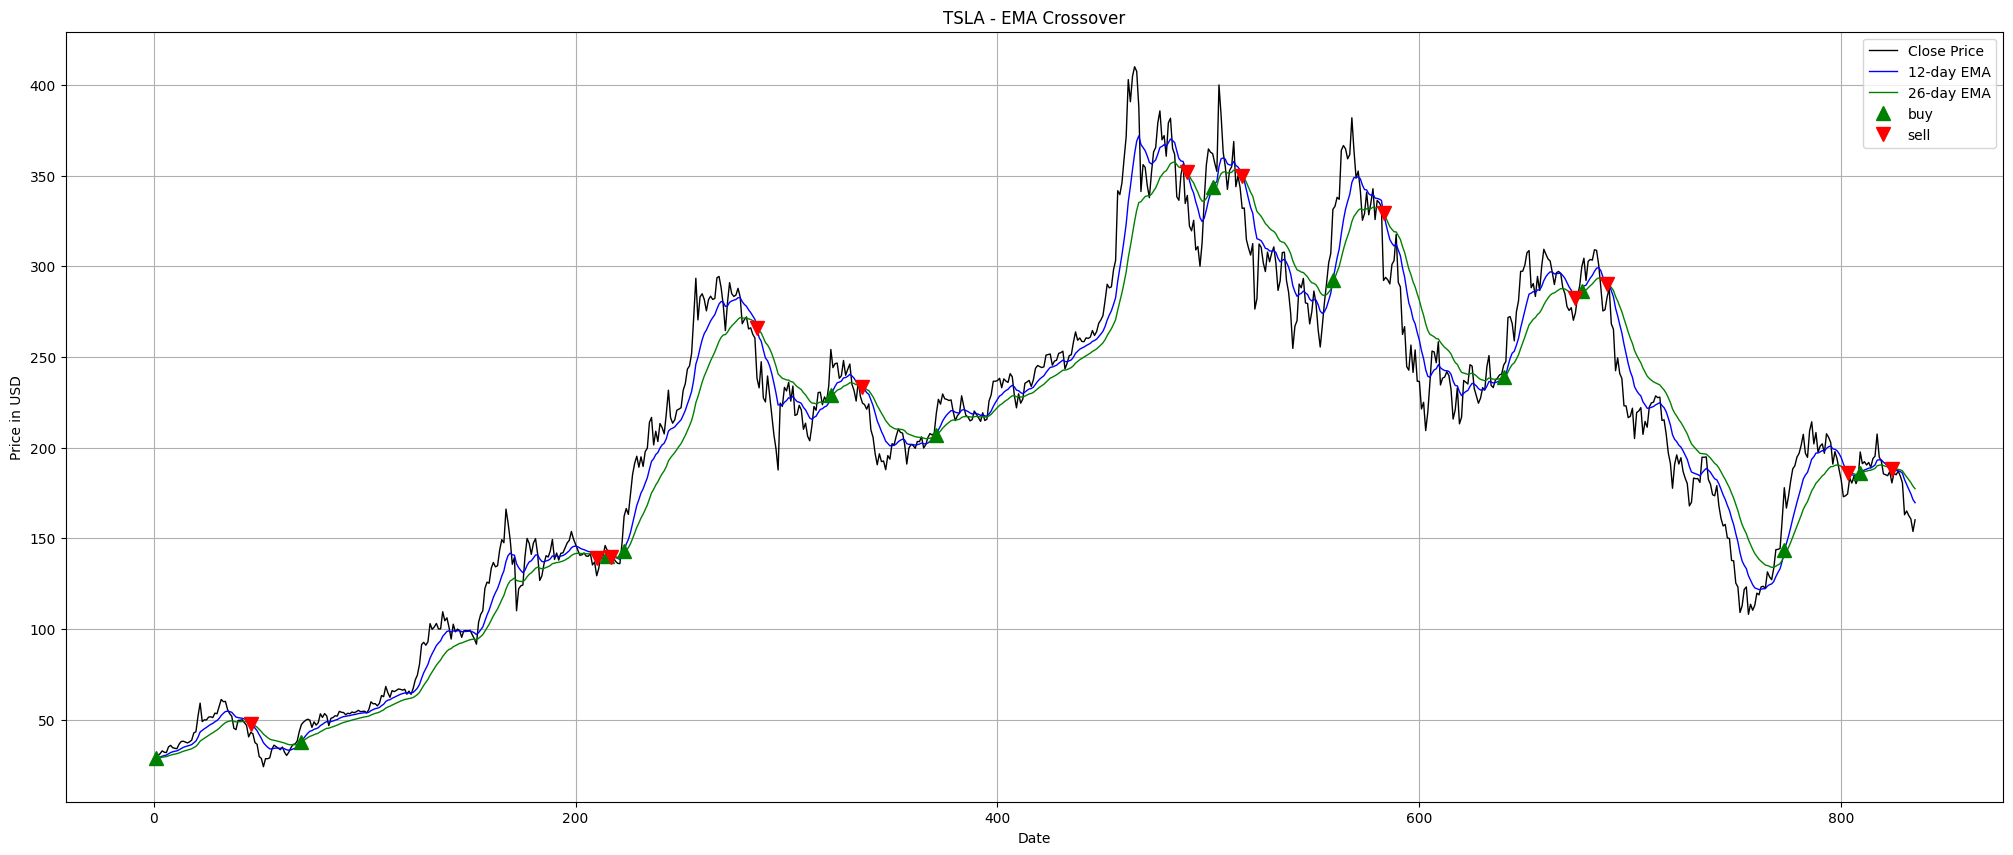

In [13]:
fig = plt.figure(figsize = (25,10))

TSLA['Close'].plot(color = 'k', lw = 1, label = 'Close Price')
TSLA['EMA_12'].plot(color = 'b', lw = 1, label = '12-day EMA')
TSLA['EMA_26'].plot(color = 'g', lw = 1, label = '26-day EMA')

plt.plot(TSLA[TSLA['EMA_Position'] == 1].index,
         TSLA['EMA_12'][TSLA['EMA_Position'] == 1],
         '^', markersize = 10, color = 'g', label = 'buy')

plt.plot(TSLA[TSLA['EMA_Position'] == -1].index,
         TSLA['EMA_12'][TSLA['EMA_Position'] == -1],
         'v', markersize = 10, color = 'r', label = 'sell')

plt.ylabel('Price in USD')
plt.xlabel('Date')
plt.title('TSLA - EMA Crossover')
plt.legend()
plt.grid()
plt.show()

fig.savefig('EMA_Crossover_Plot.png')

In [14]:
rmse = sqrt(mean_squared_error(TSLA['Close'], TSLA['EMA_12']))
rmse

14.17457329922243

In [15]:
def rsquared(x, y):
    """ Return R^2 where x and y are array-like."""

    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(x, y)
    return r_value**2

In [16]:
x = TSLA['Close'].tolist()
y = TSLA['EMA_12'].tolist()

rsquared(x, y)

0.9764326937494571

In [17]:
for index, row in TSLA.iterrows():
    if TSLA.loc[index,'Close'] > TSLA.loc[index,'EMA_12']:
        TSLA.loc[index,'EMA_12_Signal'] = 1
    elif TSLA.loc[index,'Close'] < TSLA.loc[index,'EMA_12']:
        TSLA.loc[index,'EMA_12_Signal'] = -1
    else:
        TSLA.loc[index,'EMA_12_Signal'] = 0

In [18]:
TSLA.dropna(axis=0,how='any',inplace=True)
TSLA.head()

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,...,EMA_26,EMA_40,EMA_60,MACD,RSI,SMA_Signal,SMA_Position,EMA_Signal,EMA_Position,EMA_12_Signal
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,29.109000,29.109000,29.109000,...,28.746963,28.725463,28.711869,0.067806,100.000000,0.0,0.0,1.0,1.0,1.0
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,29.440222,29.440222,29.440222,...,28.847386,28.792644,28.757469,0.165522,100.000000,0.0,0.0,1.0,0.0,1.0
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,29.897833,29.897833,29.897833,...,29.026888,28.913523,28.839869,0.333367,100.000000,0.0,0.0,1.0,0.0,1.0
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,30.480133,30.480133,30.480133,...,29.307069,29.103563,28.970015,0.583813,100.000000,0.0,0.0,1.0,0.0,1.0
5,2020-01-09,33.139999,33.253334,31.524668,32.089333,32.089333,426606000,30.748333,30.748333,30.748333,...,29.513163,29.249210,29.072288,0.715943,83.031319,0.0,0.0,1.0,0.0,1.0


In [19]:
TSLA['EMA_12_Signal']= TSLA['EMA_12_Signal'].shift(1)
TSLA

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_20,SMA_50,SMA_10,...,EMA_26,EMA_40,EMA_60,MACD,RSI,SMA_Signal,SMA_Position,EMA_Signal,EMA_Position,EMA_12_Signal
1,2020-01-03,29.366667,30.266666,29.128000,29.534000,29.534000,266677500,29.109000,29.109000,29.109000,...,28.746963,28.725463,28.711869,0.067806,100.000000,0.0,0.0,1.0,1.0,NaN
2,2020-01-06,29.364668,30.104000,29.333332,30.102667,30.102667,151995000,29.440222,29.440222,29.440222,...,28.847386,28.792644,28.757469,0.165522,100.000000,0.0,0.0,1.0,0.0,1.0
3,2020-01-07,30.760000,31.441999,30.224001,31.270666,31.270666,268231500,29.897833,29.897833,29.897833,...,29.026888,28.913523,28.839869,0.333367,100.000000,0.0,0.0,1.0,0.0,1.0
4,2020-01-08,31.580000,33.232666,31.215334,32.809334,32.809334,467164500,30.480133,30.480133,30.480133,...,29.307069,29.103563,28.970015,0.583813,100.000000,0.0,0.0,1.0,0.0,1.0
5,2020-01-09,33.139999,33.253334,31.524668,32.089333,32.089333,426606000,30.748333,30.748333,30.748333,...,29.513163,29.249210,29.072288,0.715943,83.031319,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
831,2023-04-21,164.800003,166.000000,161.320007,165.080002,165.080002,123539000,186.435500,190.798200,180.274997,...,183.898405,184.205392,183.786858,-4.205476,35.309424,0.0,0.0,0.0,0.0,-1.0
832,2023-04-24,164.649994,165.649994,158.610001,162.550003,162.550003,140006600,185.042500,189.902800,178.078998,...,182.317042,183.149032,183.090568,-5.261486,33.974557,0.0,0.0,0.0,0.0,-1.0
833,2023-04-25,159.820007,163.470001,158.750000,160.669998,160.669998,121999300,183.485500,189.178400,175.466998,...,180.713557,182.052494,182.355467,-6.178856,32.976902,0.0,0.0,0.0,0.0,-1.0
834,2023-04-26,160.289993,160.669998,153.139999,153.750000,153.750000,153364100,181.713499,188.360600,172.787999,...,178.716257,180.671884,181.417583,-7.379202,29.538571,0.0,0.0,0.0,0.0,-1.0


In [20]:
TSLA['EMA_12_Signal'].value_counts()

 1.0    473
-1.0    361
Name: EMA_12_Signal, dtype: int64

In [21]:
initial_amt = 30000
total_shares = 30
print('Account balance ',initial_amt)
print('Initial number of shares owned ',total_shares)
ini_price = TSLA.loc[1,'Close']
avg_price = TSLA['Close'].mean()
initial_val = initial_amt + ini_price*total_shares
#initial amount+total_shares*ini_price

for index, row in TSLA.iterrows():
    if TSLA.loc[index,'EMA_12_Signal'] == 1:
        if (initial_amt - TSLA.loc[index,'Close'])> 0 :
            initial_amt -= TSLA.loc[index,'Close']
            avg_price = ((avg_price*total_shares)+TSLA.loc[index,'Close'])/(total_shares+1)
            total_shares = total_shares + 1;
            TSLA.loc[index,'Action'] = "Buy"
        else:
            TSLA.loc[index,'Action'] = "Buy Alert"
    elif TSLA.loc[index,'EMA_12_Signal'] == -1:
        if total_shares - 1 > 0 :
            TSLA.loc[index,'Action'] = "Sell"
            avg_price = ((avg_price*total_shares)-TSLA.loc[index,'Close'])/(total_shares-1)
            initial_amt += TSLA.loc[index,'Close'];
            total_shares = total_shares - 1;
        else:
            TSLA.loc[index,'Action'] = "Sell Alert"
    else:
        TSLA.loc[index,'Action'] = "Hold"

print('----------------Signals Given During Day To Day Trade------------------------')
print(TSLA.tail(10))
print('----------------Results-------------------------')
print('Balance left in Account',initial_amt)
print('Total Number of shares ',total_shares)
final_amt = initial_amt

Account balance  30000
Initial number of shares owned  30
----------------Signals Given During Day To Day Trade------------------------
          Date        Open        High         Low       Close   Adj Close  \
826 2023-04-14  183.949997  186.279999  182.009995  185.000000  185.000000   
827 2023-04-17  186.320007  189.690002  182.690002  187.039993  187.039993   
828 2023-04-18  187.149994  187.690002  183.580002  184.309998  184.309998   
829 2023-04-19  179.100006  183.500000  177.649994  180.589996  180.589996   
830 2023-04-20  166.169998  169.699997  160.559998  162.990005  162.990005   
831 2023-04-21  164.800003  166.000000  161.320007  165.080002  165.080002   
832 2023-04-24  164.649994  165.649994  158.610001  162.550003  162.550003   
833 2023-04-25  159.820007  163.470001  158.750000  160.669998  160.669998   
834 2023-04-26  160.289993  160.669998  153.139999  153.750000  153.750000   
835 2023-04-27  152.639999  160.479996  152.369995  160.190002  160.190002   

     

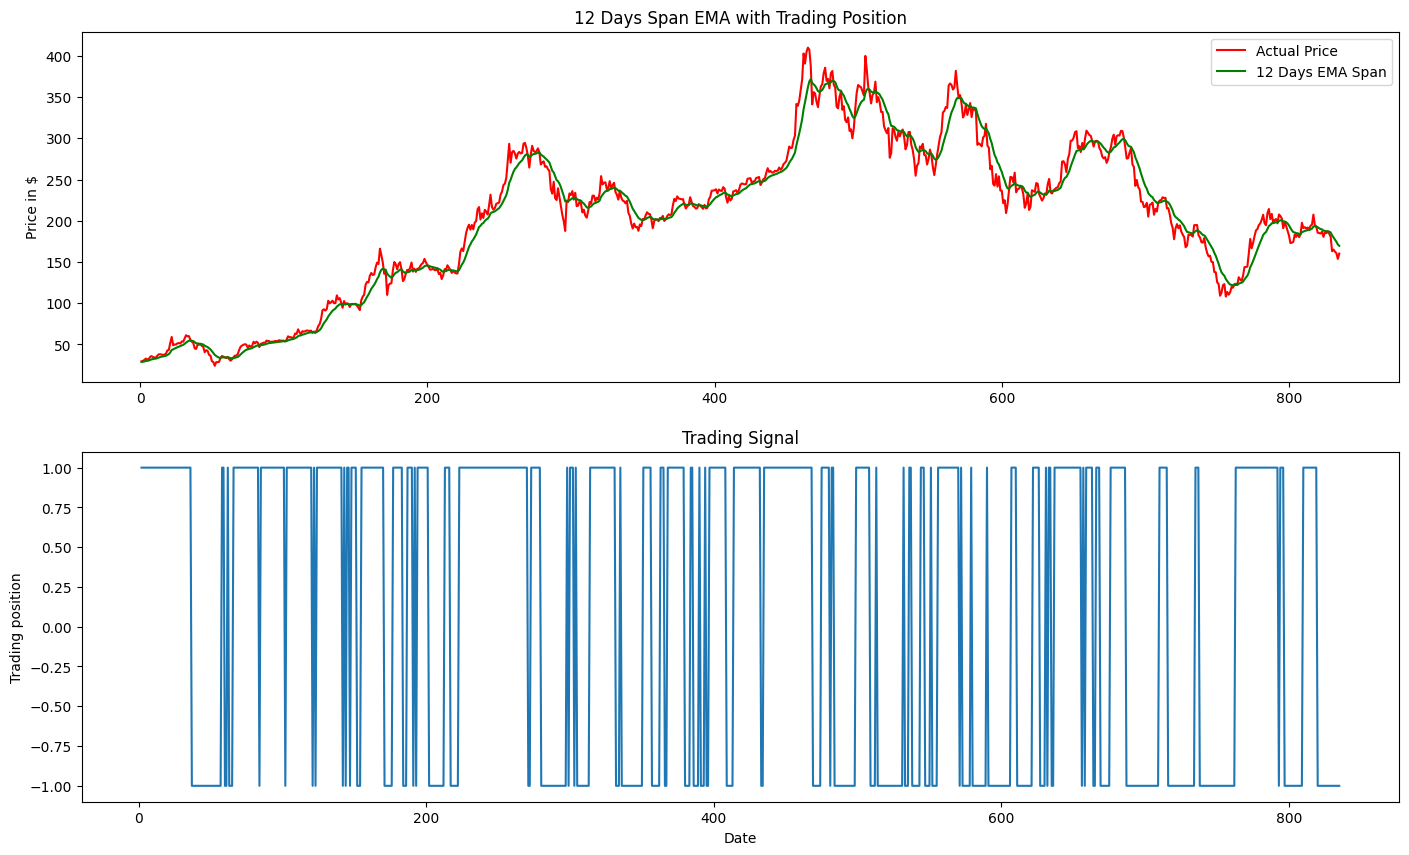

In [22]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(17,10))

ax1.plot(TSLA['Close'], label='Actual Price', color = 'red')
ax1.plot(TSLA['EMA_12'], label = '12 Days EMA Span', color = 'green')
ax1.set_title('12 Days Span EMA with Trading Position')
ax1.set_ylabel('Price in $')
ax1.legend(loc='best')

ax2.plot(TSLA['EMA_12_Signal'], label='Trading position')
ax2.set_title('Trading Signal')
ax2.set_xlabel('Date')
ax2.set_ylabel('Trading position')

fig.savefig('Trading_Strategy.png')